# Fashion Product generation using DCGAN (Deep Convolutional GAN)

In [1]:
import torch
from torch import nn
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


<h3>Set device</h3>

In [3]:
device = 'cuda'

<h3>Generator</h3>

In [4]:
class Generator(nn.Module):
    
    """
    Generator of the DCGAN.
    
    Parameters
    ----------
    noise_channel: int
        number of channels in the random noise vector.
    hidden_channels: tuple
        tuple of numbers of channels in the hidden layers.
    image_channel: int
        number of channels in the image generated.
    kernel_sizes: tuple
        tuple of kernel sizes.
    strides: tuple
        tuple of kernel strides.
    """
    
    def __init__(self, noise_channel, hidden_channels, image_channel, kernel_sizes, strides):
        
        super(Generator, self).__init__()
        
        self.noise_channel = noise_channel
        self.hidden_channels = hidden_channels
        self.image_channel = image_channel
        self.kernel_sizes = kernel_sizes
        self.strides = strides
        
        layers_list = []
        
        curr_input_channel = noise_channel
        
        for hidden_channel, kernel_size, stride in zip(hidden_channels,kernel_sizes, strides):
            layer = nn.Sequential(nn.ConvTranspose2d(curr_input_channel, hidden_channel, kernel_size, stride),
                                  nn.BatchNorm2d(hidden_channel),
                                  nn.ReLU())
            layers_list.append(layer)
            curr_input_channel = hidden_channel
        
        layer = nn.Sequential(nn.ConvTranspose2d(hidden_channel, image_channel, kernel_sizes[-1], strides[-1]), nn.Tanh())
        layers_list.append(layer)
        
        self.generator = nn.Sequential(*layers_list)
        
    
    def forward(self, noise):
        
        """
        Perform the forward pass.

        Parameters
        ----------
        noise: Tensor
            batch of random noise vectors.

        Returns
        -------
        images: Tensor
            images generated from the noise vectors.
        """
        
        return self.generator(noise)

<h3>Discriminator</h3>

In [5]:
class Discriminator(nn.Module):
    
    """
    Discriminator of the DCGAN.
    
    Parameters
    ----------
    image_channel: int
        number of channels in the image generated.
    hidden_channels: tuple
        tuple of numbers of channels in the hidden layers.
    kernel_sizes: tuple
        tuple of kernel sizes.
    strides: tuple
        tuple of kernel strides.
    """
    
    def __init__(self, image_channel, hidden_channels, kernel_sizes, strides):
        super(Discriminator, self).__init__()
        
        self.image_channel = image_channel
        self.hidden_channels = hidden_channels
        self.kernel_sizes = kernel_sizes
        self.strides = strides
        
        layers_list = []
        curr_input_channel = image_channel
        
        for hidden_channel, kernel_size, stride in zip(hidden_channels, kernel_sizes, strides):
            layer = nn.Sequential(nn.Conv2d(curr_input_channel, hidden_channel, kernel_size, stride),
                                  nn.BatchNorm2d(hidden_channel),
                                  nn.LeakyReLU(negative_slope = 0.2))
            layers_list.append(layer)
            curr_input_channel = hidden_channel
        
        layer = nn.Sequential(nn.Conv2d(hidden_channel, 1, kernel_sizes[-1], strides[-1]), nn.Sigmoid())
        layers_list.append(layer)
        
        self.discriminator = nn.Sequential(*layers_list)
    
    def forward(self, images):
        
        """
        Perform the forward pass.

        Parameters
        ----------
        images:
            batch of images.

        Returns
        -------
        predictions: Tensor
            binary predictions of the input images.
        """
        
        return self.discriminator(images)

<h3>function to initialize weights of generator and discriminator</h3>

In [6]:
def initialize_weights(module):
    
    """
    Initialize the weights of generator and discriminator.
    
    Parameters
    ----------
    module: nn.Module
        module whose weights are to be initialized.
        
    Returns
    -------
    None
    """
    
    if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(module.weight, 0.0, 0.02)
    elif isinstance(module, nn.BatchNorm2d):
        nn.init.normal_(module.weight, 0.0, 0.02)
        nn.init.constant_(module.bias, 0.0)

<h3>function to show generated images</h3>

In [7]:
def show_images(images, image_size = (28,28)):
    
    """
    Show the grid of images.

    Parameters
    ----------
    images: Tensor
        batch of images to be displayed.
    image_size: tuple
        size of an image.

    Returns
    -------
    None
    """

    images = (images + 1) / 2
    images = images.detach().cpu()
    image_grid = make_grid(images, nrow = 5)
    plt.imshow(image_grid.permute(1,2,0), cmap = 'gray')
    plt.show()

<h3>set input, image and output channels</h3>

In [8]:
noise_channel = 64
image_channel = 1
output_channel = 1

<h3>create generator</h3>

In [9]:
gen = Generator(noise_channel = noise_channel,
                      hidden_channels = (256, 128, 64),
                      image_channel = image_channel,
                      kernel_sizes = (3, 4, 3, 4),
                      strides = (2, 1, 2, 2)).to(device)

<h3>create discriminator</h3>

In [10]:
disc = Discriminator(image_channel = image_channel,
                              hidden_channels = (16, 32),
                              kernel_sizes = (4, 4, 4),
                              strides = (2, 2, 2)).to(device)

<h3>initialize weights of generator and discriminator</h3>

In [11]:
gen = gen.apply(initialize_weights)
disc = disc.apply(initialize_weights)

<h3>train GAN</h3>

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


  0%|          | 0/469 [00:00<?, ?it/s]

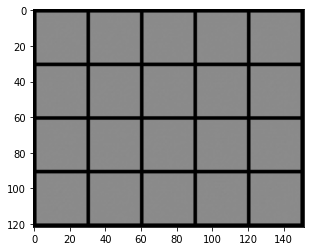

Epoch 1 : Generator's loss : 0.8006879964362837, Discriminator's loss : 0.593911700411392


  0%|          | 0/469 [00:00<?, ?it/s]

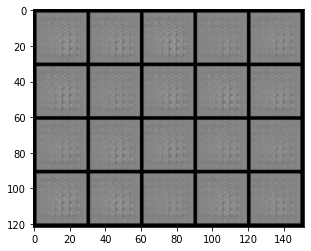

Epoch 2 : Generator's loss : 1.5719041920928305, Discriminator's loss : 0.328275247359835


  0%|          | 0/469 [00:00<?, ?it/s]

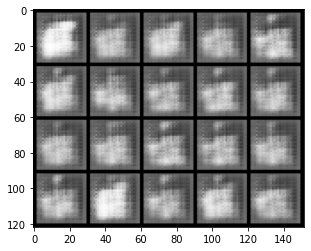

Epoch 3 : Generator's loss : 1.1992146025842696, Discriminator's loss : 0.5394442893231093


  0%|          | 0/469 [00:00<?, ?it/s]

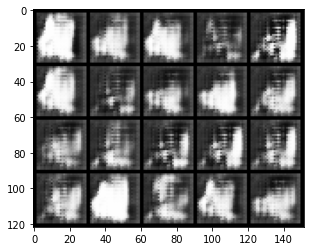

Epoch 4 : Generator's loss : 1.024361371930474, Discriminator's loss : 0.6057489471140701


  0%|          | 0/469 [00:00<?, ?it/s]

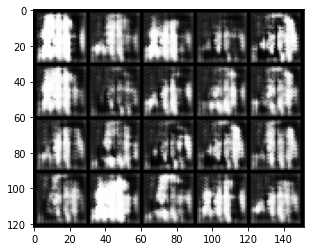

Epoch 5 : Generator's loss : 0.8423634118108607, Discriminator's loss : 0.6463894719508156


  0%|          | 0/469 [00:00<?, ?it/s]

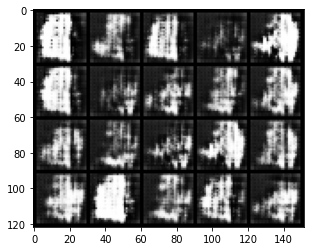

Epoch 6 : Generator's loss : 0.8183695732403412, Discriminator's loss : 0.6531590021241194


  0%|          | 0/469 [00:00<?, ?it/s]

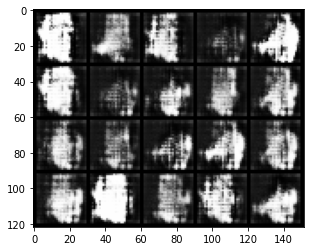

Epoch 7 : Generator's loss : 0.7812903177763607, Discriminator's loss : 0.6621370628190193


  0%|          | 0/469 [00:00<?, ?it/s]

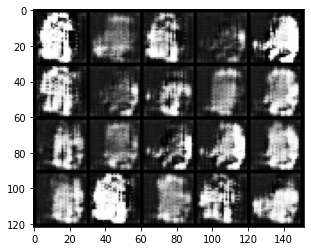

Epoch 8 : Generator's loss : 0.7567028175793222, Discriminator's loss : 0.6742335053395107


  0%|          | 0/469 [00:00<?, ?it/s]

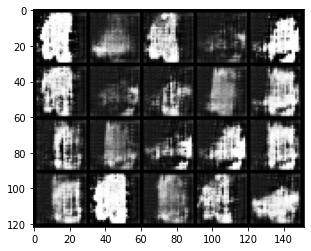

Epoch 9 : Generator's loss : 0.7402615245979732, Discriminator's loss : 0.6817648166786633


  0%|          | 0/469 [00:00<?, ?it/s]

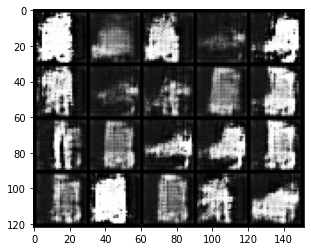

Epoch 10 : Generator's loss : 0.7185926564466725, Discriminator's loss : 0.6900354407743604


  0%|          | 0/469 [00:00<?, ?it/s]

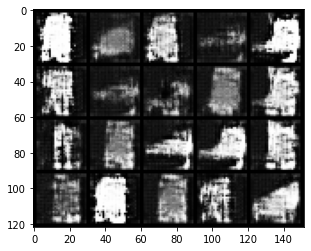

Epoch 11 : Generator's loss : 0.7088793653414956, Discriminator's loss : 0.6966433361140904


  0%|          | 0/469 [00:00<?, ?it/s]

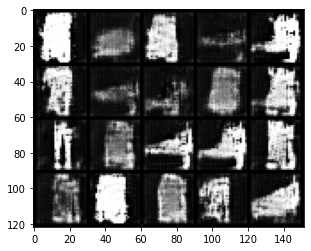

Epoch 12 : Generator's loss : 0.7072163733846343, Discriminator's loss : 0.6968840295826194


  0%|          | 0/469 [00:00<?, ?it/s]

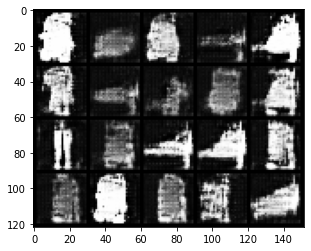

Epoch 13 : Generator's loss : 0.700206650599742, Discriminator's loss : 0.6977381499083057


  0%|          | 0/469 [00:00<?, ?it/s]

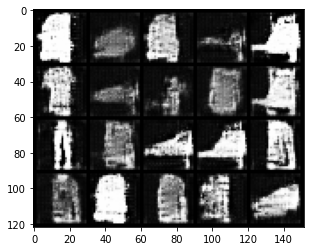

Epoch 14 : Generator's loss : 0.6965257703368344, Discriminator's loss : 0.6991151825451394


  0%|          | 0/469 [00:00<?, ?it/s]

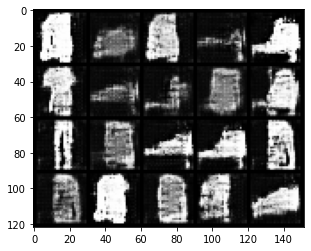

Epoch 15 : Generator's loss : 0.6938245482027912, Discriminator's loss : 0.7001569770546611


  0%|          | 0/469 [00:00<?, ?it/s]

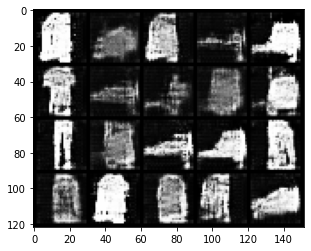

Epoch 16 : Generator's loss : 0.6938391976010825, Discriminator's loss : 0.6995757450935429


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17 : Generator's loss : 0.6944011998837436, Discriminator's loss : 0.6995122798724469


  0%|          | 0/469 [00:00<?, ?it/s]

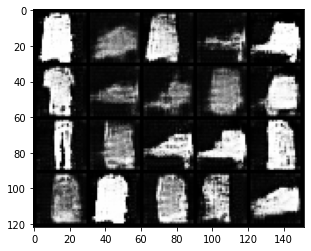

Epoch 18 : Generator's loss : 0.6956162005345196, Discriminator's loss : 0.6989236167753174


  0%|          | 0/469 [00:00<?, ?it/s]

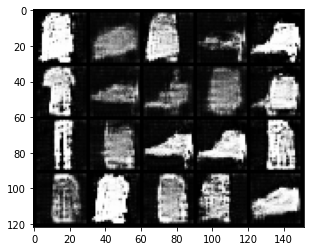

Epoch 19 : Generator's loss : 0.6927747301963855, Discriminator's loss : 0.6981775467075518


  0%|          | 0/469 [00:00<?, ?it/s]

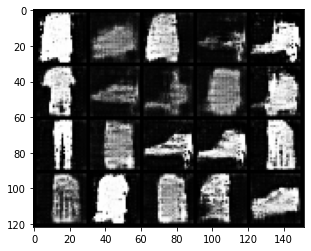

Epoch 20 : Generator's loss : 0.6945443110171158, Discriminator's loss : 0.6975184353684057


  0%|          | 0/469 [00:00<?, ?it/s]

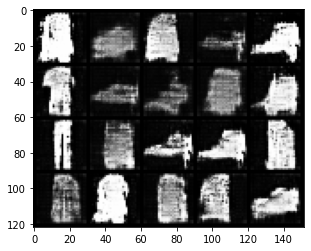

Epoch 21 : Generator's loss : 0.6958111720298653, Discriminator's loss : 0.6968165275130445


  0%|          | 0/469 [00:00<?, ?it/s]

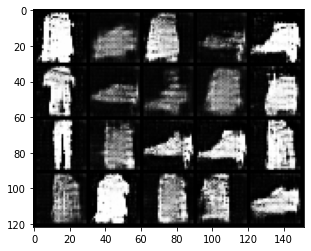

Epoch 22 : Generator's loss : 0.6947132425267559, Discriminator's loss : 0.6963769266091938


  0%|          | 0/469 [00:00<?, ?it/s]

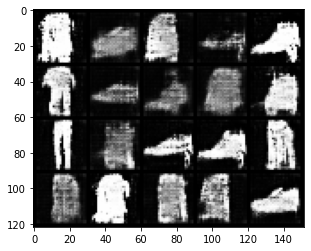

Epoch 23 : Generator's loss : 0.693973961034055, Discriminator's loss : 0.6961187256424666


  0%|          | 0/469 [00:00<?, ?it/s]

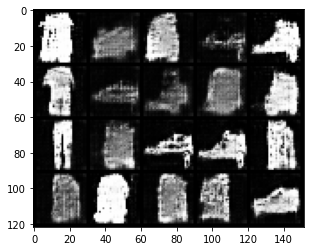

Epoch 24 : Generator's loss : 0.6942655028564844, Discriminator's loss : 0.6959582803600124


  0%|          | 0/469 [00:00<?, ?it/s]

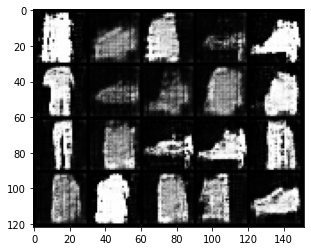

Epoch 25 : Generator's loss : 0.6940368072056313, Discriminator's loss : 0.6957897461299449


  0%|          | 0/469 [00:00<?, ?it/s]

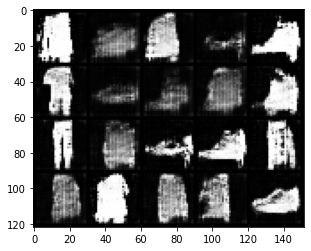

Epoch 26 : Generator's loss : 0.6953776731674097, Discriminator's loss : 0.695480696936406


  0%|          | 0/469 [00:00<?, ?it/s]

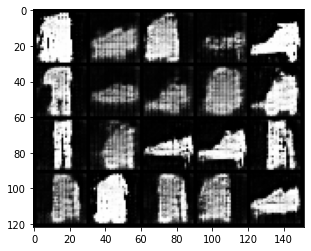

Epoch 27 : Generator's loss : 0.6942338946023221, Discriminator's loss : 0.6951980454835303


  0%|          | 0/469 [00:00<?, ?it/s]

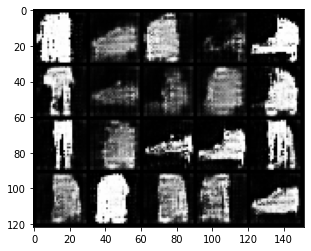

Epoch 28 : Generator's loss : 0.6951005925247664, Discriminator's loss : 0.6950463355222999


  0%|          | 0/469 [00:00<?, ?it/s]

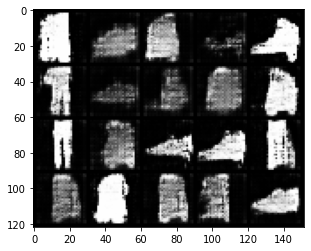

Epoch 29 : Generator's loss : 0.6944656677083421, Discriminator's loss : 0.6948289615767342


  0%|          | 0/469 [00:00<?, ?it/s]

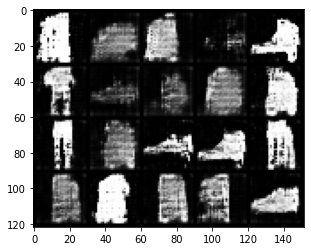

Epoch 30 : Generator's loss : 0.6943988313298743, Discriminator's loss : 0.6947360369188191


  0%|          | 0/469 [00:00<?, ?it/s]

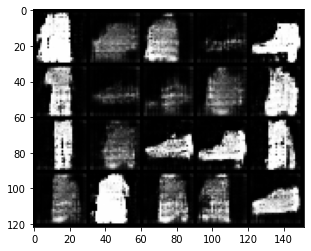

Epoch 31 : Generator's loss : 0.6948726674132764, Discriminator's loss : 0.6946275719701608


  0%|          | 0/469 [00:00<?, ?it/s]

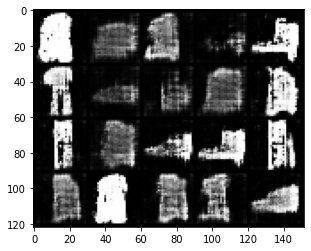

Epoch 32 : Generator's loss : 0.6961946417527921, Discriminator's loss : 0.6944148723504691


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 33 : Generator's loss : 0.6945394813887346, Discriminator's loss : 0.6944065195665177


  0%|          | 0/469 [00:00<?, ?it/s]

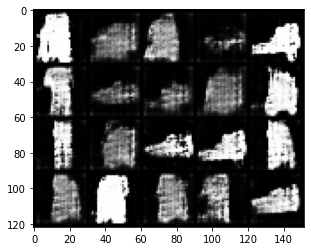

Epoch 34 : Generator's loss : 0.6938732436725071, Discriminator's loss : 0.6943642362348561


  0%|          | 0/469 [00:00<?, ?it/s]

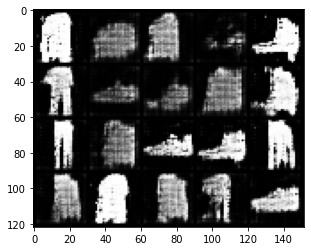

Epoch 35 : Generator's loss : 0.6947376267996423, Discriminator's loss : 0.6942796272509641


  0%|          | 0/469 [00:00<?, ?it/s]

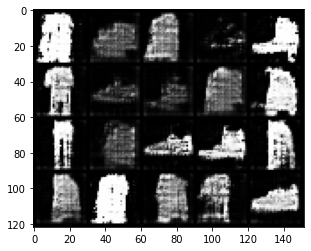

Epoch 36 : Generator's loss : 0.6940971868378776, Discriminator's loss : 0.6940915908640636


  0%|          | 0/469 [00:00<?, ?it/s]

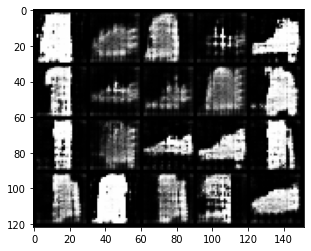

Epoch 37 : Generator's loss : 0.6953342658624466, Discriminator's loss : 0.6940930256965572


  0%|          | 0/469 [00:00<?, ?it/s]

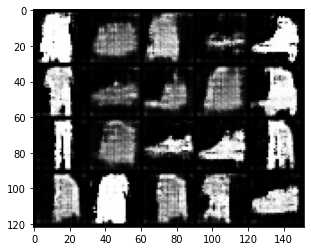

Epoch 38 : Generator's loss : 0.6949501038868544, Discriminator's loss : 0.6940303217373422


  0%|          | 0/469 [00:00<?, ?it/s]

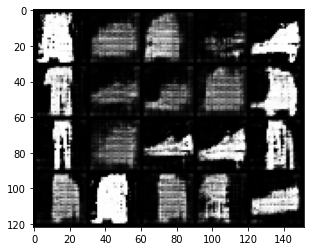

Epoch 39 : Generator's loss : 0.6947542136666108, Discriminator's loss : 0.6940448610767372


  0%|          | 0/469 [00:00<?, ?it/s]

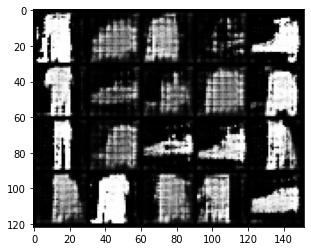

Epoch 40 : Generator's loss : 0.6952664190009713, Discriminator's loss : 0.6939063946575498


In [12]:
num_epochs = 40 # number of epochs

batch_size = 128 # number of images in a batch

criterion = nn.BCELoss() # object to compute loss of generator and discriminator

learning_rate = 0.0002 # larning rate of the optimizers
betas = (0.5, 0.999)

gen_optim = torch.optim.Adam(gen.parameters(), lr = learning_rate, betas = betas) # generator's optimizer

disc_optim = torch.optim.Adam(disc.parameters(), lr = learning_rate, betas = betas) # discriminator's optimizer

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# MNIST data loader
data_loader = DataLoader(FashionMNIST('.', download = True, transform = transform), 
                        batch_size = batch_size, shuffle = True)

curr_step = 0

noise_for_gif = torch.randn((20, noise_channel, 1, 1), device = device)
images_for_gif = []

for epoch in range(num_epochs):
    
    mean_gen_loss = 0
    mean_disc_loss = 0
    counter = 0
    
    for real_images, _ in tqdm(data_loader):
        
        curr_batch_size = real_images.shape[0] # number of real images in a batch
        real_images = real_images.to(device) # flatten images
        
        # train discriminator
        
        disc_optim.zero_grad()
        noise = torch.randn((curr_batch_size, noise_channel, 1, 1), device = device)
        fake_images = gen(noise)
        fake_pred = disc(fake_images.detach())
        real_pred = disc(real_images)
        disc_loss = (criterion(fake_pred, torch.zeros_like(fake_pred)) + criterion(real_pred, torch.ones_like(real_pred))) / 2
        disc_loss.backward(retain_graph = True)
        disc_optim.step()
        
        # train generator
        
        gen_optim.zero_grad()
        noise = torch.randn((curr_batch_size, noise_channel, 1, 1), device = device)
        fake_images = gen(noise)
        fake_pred = disc(fake_images)
        gen_loss = criterion(fake_pred, torch.ones_like(fake_pred))
        gen_loss.backward(retain_graph = True)
        gen_optim.step()
        
        mean_gen_loss += gen_loss.item()
        mean_disc_loss += disc_loss.item()
        counter += 1

        if (curr_step % 500) == 0:
            fake_images = gen(noise_for_gif)
            show_images(fake_images)
            images = (fake_images + 1) / 2
            images = images.detach().cpu()
            image_grid = make_grid(images, nrow = 5).permute(1,2,0)
            image_grid_arr = (255 * image_grid.numpy()).astype(np.uint8)
            images_for_gif.append(Image.fromarray(image_grid_arr))
        curr_step += 1
    
    mean_gen_loss /= counter
    mean_disc_loss /= counter
    
    # print current losses
    print(f"Epoch {epoch+1} : Generator's loss : {mean_gen_loss}, Discriminator's loss : {mean_disc_loss}")

<h3>generate images using trained GAN</h3>

In [13]:
num_images = 20

noise = torch.randn((20, noise_channel, 1, 1), device = device)

fake_images = gen(noise)

<h3>show fake images</h3>

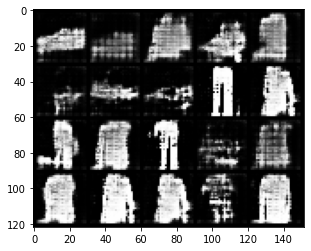

In [14]:
image_grid = show_images(fake_images)

<h3>show real images</h3>

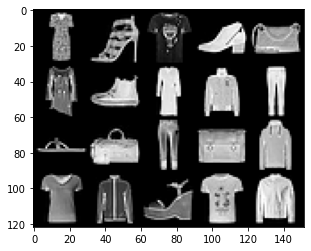

In [15]:
real_images = real_images[:20].view(-1, 1, 28, 28)

show_images(real_images, (1, 28, 28))

<h3>save training GIF</h3>

In [16]:
images_for_gif[0].save(f'/content/gdrive/My Drive/images_for_gif/fashion.gif', save_all = True, append_images=images_for_gif[1:], optimize=False, duration=300, loop=0)